In [43]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# use get_db_url function to connect to the codeup db
from env import get_db_url
from sklearn.impute import SimpleImputer

# custom module imports
import acquire as aq
import wrangle_zillow as wz

### 1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

- Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
- Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.
- Only include properties that include a latitude and longitude value.

In [44]:
df = aq.get_zillow_data()

In [45]:
df.head()

,parcelid,heatingorsystemtypeid,architecturalstyletypeid,buildingclasstypeid,airconditioningtypeid,id,logerror,transactiondate,id,basementsqft,...,propertylandusetypeid,propertylandusedesc,architecturalstyledesc,heatingorsystemdesc,storytypeid,storydesc,typeconstructiontypeid,typeconstructiondesc,logerror,transactiondate
0,14297519,NaN,NaN,NaN,NaN,0,0.025595,2017-01-01,1727539,NaN,...,261,Single Family Residential,None,None,NaN,None,NaN,None,0.025595,2017-01-01
1,17052889,NaN,NaN,NaN,NaN,1,0.055619,2017-01-01,1387261,NaN,...,261,Single Family Residential,None,None,NaN,None,NaN,None,0.055619,2017-01-01
2,14186244,NaN,NaN,NaN,NaN,2,0.005383,2017-01-01,11677,NaN,...,261,Single Family Residential,None,None,NaN,None,NaN,None,0.005383,2017-01-01
3,12177905,2.0,NaN,NaN,NaN,3,-0.103410,2017-01-01,2288172,NaN,...,261,Single Family Residential,None,Central,NaN,None,NaN,None,-0.103410,2017-01-01
4,10887214,2.0,NaN,NaN,1.0,4,0.006940,2017-01-01,1970746,NaN,...,266,Condominium,None,Central,NaN,None,NaN,None,0.006940,2017-01-01


### 2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [46]:
df.shape

(77579, 74)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77579 entries, 0 to 77578
Data columns (total 74 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77579 non-null  int64  
 1   heatingorsystemtypeid         49571 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   buildingclasstypeid           15 non-null     float64
 4   airconditioningtypeid         25007 non-null  float64
 5   id                            77579 non-null  int64  
 6   logerror                      77579 non-null  float64
 7   transactiondate               77579 non-null  object 
 8   id                            77579 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77579 non-null  float64
 11  bedroomcnt                    77579 non-null  float64
 12  buildingqualitytypeid         49809 non-null  float64
 13  c

In [48]:
# check dup parcelid
df.parcelid.value_counts()

10857130    3
11991059    3
12612211    3
11429175    2
13863275    2
           ..
13968654    1
12659983    1
14154852    1
11388525    1
14298875    1
Name: parcelid, Length: 77381, dtype: int64

In [49]:
# drop dupplicate columns
df = df.loc[:,~df.columns.duplicated()]

In [50]:
# drop duplicate parcelid keeping the latest one by transaction date
df = df.sort_values('transactiondate').drop_duplicates('parcelid',keep='last')

### 3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [51]:
def nulls_by_col(df):
    # get column names paired with number of nulls in that column
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    # calculate percentage of rows missing for each column
    prcnt_miss = num_missing / rows * 100
    # create a dataframe with the info
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 
                                 'percent_rows_missing': prcnt_miss})
    return cols_missing

In [52]:
nulls_by_col(df)

,num_rows_missing,percent_rows_missing
parcelid,0,0.000000
heatingorsystemtypeid,27941,36.108347
architecturalstyletypeid,77175,99.733785
buildingclasstypeid,77366,99.980615
airconditioningtypeid,52428,67.753066
...,...,...
propertylandusedesc,0,0.000000
architecturalstyledesc,77175,99.733785
heatingorsystemdesc,27941,36.108347
storydesc,77331,99.935385


### Takeaways

- varied number of null values
- drop columns that have more than 50% missing values

### 4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [53]:
def nulls_by_row(df):
    # number of columns with missing values in each row
    num_missing = df.isnull().sum(axis = 1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 
                                 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index().set_index('num_cols_missing')
    return rows_missing

In [54]:
nulls_by_row(df)

,percent_cols_missing,num_rows
num_cols_missing,,
23,33.82352941176471,2
24,35.294117647058826,13
25,36.76470588235294,24
26,38.23529411764706,65
27,39.705882352941174,316
28,41.17647058823529,455
29,42.64705882352941,5270
30,44.11764705882353,3455
31,45.588235294117645,9891


## Takeaways

- 2 rows with missing values in 23 colummns
- Drop rows that have more than 75% missing values

## Prepare

### 1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

In [55]:
df.propertylandusedesc.value_counts()


Single Family Residential                     52320
Condominium                                   19294
Duplex (2 Units, Any Combination)              2009
Planned Unit Development                       1944
Quadruplex (4 Units, Any Combination)           727
Triplex (3 Units, Any Combination)              535
Cluster Home                                    333
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       58
Residential General                              37
Cooperative                                      29
Commercial/Office/Residential Mixed Used         15
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

In [56]:
# remove non single unit props
df = df[(df.propertylandusedesc == 'Single Family Residential') |
          (df.propertylandusedesc == 'Mobile Home') |
          (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
          (df.propertylandusedesc == 'Townhouse')]

In [57]:
# confirm changes and new shape of df
df.shape

(52458, 68)

### Check for outliers

<AxesSubplot:>

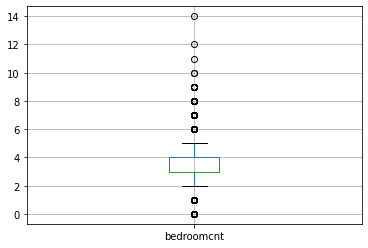

In [58]:
df.boxplot('bedroomcnt')

<AxesSubplot:>

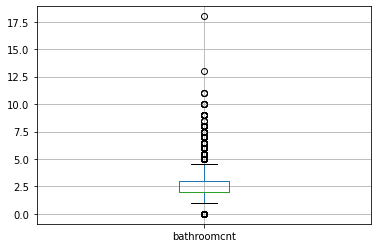

In [59]:
df.boxplot('bathroomcnt')

<AxesSubplot:>

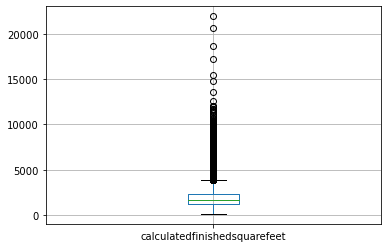

In [60]:
df.boxplot('calculatedfinishedsquarefeet')

In [61]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:
        # get quartiles
        q1, q3 = df[f'{col}'].quantile([.25, .75])  
        # calculate interquartile range
        iqr = q3 - q1   
        # get upper bound
        upper_bound = q3 + k * iqr 
        # get lower bound
        lower_bound = q1 - k * iqr   

        # return dataframe without outliers
        
        df = df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]
        
    return df

In [62]:
outlier_cols = ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']

In [63]:
df = remove_outliers(df, 1.5, outlier_cols)

In [64]:
df.shape

(48330, 68)

### 2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

In [65]:
def remove_columns(df, cols_to_remove):
    df = df.drop(columns=cols_to_remove)
    return df
                 
                 
def handle_missing_values(df, prop_required_column=0.5 , prop_required_row=0.75):
    threshold = int(round(prop_required_column * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

# combined in one function
def data_prep(df, cols_to_remove=[], prop_required_column=0.5, prop_required_row=0.75):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df


In [66]:
df = data_prep(df)

In [67]:
df.shape

(48327, 34)

### Decide how to handle remaining nulls

In [68]:
# find cols with nulls
df.isnull().sum()[df.isnull().sum() > 0]

heatingorsystemtypeid         16766
buildingqualitytypeid         16847
calculatedbathnbr                14
finishedsquarefeet12            154
fullbathcnt                      14
lotsizesquarefeet               257
propertyzoningdesc            16858
regionidcity                    898
regionidzip                      15
unitcnt                       16839
yearbuilt                        21
structuretaxvaluedollarcnt       61
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         4
censustractandblock              79
heatingorsystemdesc           16766
dtype: int64

In [69]:
# look at cols with large amounts of nulls
df.isnull().sum()[df.isnull().sum()>16000]

heatingorsystemtypeid    16766
buildingqualitytypeid    16847
propertyzoningdesc       16858
unitcnt                  16839
heatingorsystemdesc      16766
dtype: int64

In [70]:
cols_with_nulls = ['heatingorsystemtypeid', 'buildingqualitytypeid',
                  'propertyzoningdesc', 'unitcnt', 'heatingorsystemdesc']

In [71]:
# value counts for cals with large amounts of nulls

for col in cols_with_nulls:
    print(col)
    print(df[col].value_counts(dropna=False))
    

heatingorsystemtypeid
2.0     18900
NaN     16766
7.0     12078
6.0       483
20.0       68
13.0       16
1.0         7
18.0        6
10.0        2
24.0        1
Name: heatingorsystemtypeid, dtype: int64
buildingqualitytypeid
NaN     16847
6.0     10156
8.0      8078
4.0      7958
7.0      3009
5.0      1286
9.0       669
11.0      152
3.0       113
10.0       45
12.0        9
1.0         4
2.0         1
Name: buildingqualitytypeid, dtype: int64
propertyzoningdesc
NaN           16858
LAR1           6111
LARS           1349
LBR1N          1082
SCUR2           699
              ...  
LAR1-1(T)-        1
LOR1P*            1
WHP*              1
ESR3YY            1
PACM*             1
Name: propertyzoningdesc, Length: 1230, dtype: int64
unitcnt
1.0    31469
NaN    16839
2.0       18
3.0        1
Name: unitcnt, dtype: int64
heatingorsystemdesc
Central       18900
NaN           16766
Floor/Wall    12078
Forced air      483
Solar            68
None             16
Baseboard         7
Radiant   

In [72]:
# drop columns with too many nulls 

df = df.drop(columns=['heatingorsystemtypeid', 'buildingqualitytypeid',
                  'propertyzoningdesc', 'unitcnt', 'heatingorsystemdesc'])

In [73]:
df.shape

(48327, 29)

In [74]:
# remaining nulls
df.isnull().sum()[df.isnull().sum() > 0]

calculatedbathnbr              14
finishedsquarefeet12          154
fullbathcnt                    14
lotsizesquarefeet             257
regionidcity                  898
regionidzip                    15
yearbuilt                      21
structuretaxvaluedollarcnt     61
taxvaluedollarcnt               1
landtaxvaluedollarcnt           1
taxamount                       4
censustractandblock            79
dtype: int64

In [75]:
cat_cols = ['calculatedbathnbr','fullbathcnt', 'regionidcity', 'regionidzip',
           'censustractandblock']

In [76]:
# get value counts for discrete cols

for col in cat_cols:
    print(col)
    print(df[col].value_counts(dropna=False))

calculatedbathnbr
2.0    21800
3.0    10356
1.0     8979
2.5     3900
4.0     1689
1.5      831
3.5      758
NaN       14
Name: calculatedbathnbr, dtype: int64
fullbathcnt
2.0    25711
3.0    11115
1.0     9810
4.0     1677
NaN       14
Name: fullbathcnt, dtype: int64
regionidcity
12447.0    10369
5534.0      1743
40227.0     1460
46298.0     1362
16764.0     1037
           ...  
31134.0        2
53162.0        1
21395.0        1
10815.0        1
36078.0        1
Name: regionidcity, Length: 176, dtype: int64
regionidzip
97319.0    742
97318.0    663
97329.0    542
97328.0    515
97118.0    460
          ... 
96434.0      2
97092.0      1
96038.0      1
96467.0      1
96148.0      1
Name: regionidzip, Length: 379, dtype: int64
censustractandblock
NaN             79
6.037920e+13    32
6.059032e+13    21
6.037920e+13    20
6.037901e+13    20
                ..
6.037571e+13     1
6.037300e+13     1
6.037185e+13     1
6.037107e+13     1
6.111001e+13     1
Name: censustractandblock, Length:

- other missing values will be imputed. This will be done after splitting the data. 

In [77]:
# split df
train, validate, test = wz.split_data(df)

In [78]:
# checks nulls in train split
train.isnull().sum()[train.isnull().sum()>0]

calculatedbathnbr               6
finishedsquarefeet12           85
fullbathcnt                     6
lotsizesquarefeet             150
regionidcity                  516
regionidzip                     9
yearbuilt                      14
structuretaxvaluedollarcnt     30
taxamount                       3
censustractandblock            44
dtype: int64

In [36]:
train.head()

,parcelid,id,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusedesc
48481,14324605,48500,0.121156,2017-06-20,4.0,4.0,4.0,2918.0,2918.0,6059.0,...,96957.0,7.0,2006.0,683277.0,2862804.0,2016.0,2179527.0,30394.08,6.059063e+13,Single Family Residential
55982,14002345,56004,0.016625,2017-07-11,1.5,3.0,1.5,1276.0,1276.0,6059.0,...,96203.0,6.0,1964.0,29668.0,46187.0,2016.0,16519.0,870.70,6.059088e+13,Single Family Residential
36075,11768209,36090,-0.235871,2017-05-15,1.0,2.0,1.0,804.0,804.0,6037.0,...,95992.0,0.0,1905.0,31780.0,58845.0,2016.0,27065.0,772.83,6.037228e+13,Single Family Residential
67163,11301907,67191,-0.072828,2017-08-16,3.0,3.0,3.0,1487.0,1487.0,6037.0,...,97318.0,0.0,1990.0,152500.0,181000.0,2016.0,28500.0,3029.74,6.037901e+13,Single Family Residential
26328,12346075,26341,0.012575,2017-04-14,3.0,3.0,3.0,1072.0,1072.0,6037.0,...,96208.0,0.0,1956.0,120100.0,379521.0,2016.0,259421.0,4486.93,6.037554e+13,Single Family Residential


In [79]:
# impute missing values using most frequent for cat cols

def impute(df, my_strategy, column_list):
    ''' takes in a df, strategy, and cloumn list
        return df with listed columns imputed using imputing stratagy
    '''
    # build imputer    
    imputer = SimpleImputer(strategy=my_strategy)  
    # fit/transform selected columns
    df[column_list] = imputer.fit_transform(df[column_list]) 

    return df

In [80]:
cat_cols

['calculatedbathnbr',
 'fullbathcnt',
 'regionidcity',
 'regionidzip',
 'censustractandblock']

In [81]:
train = impute(train, 'most_frequent', 
            cat_cols)


- no NaN values so the desired changes have been applied and imputed values applied

In [82]:
# confirm changes and check remaining nulls
train.isnull().sum()[df.isnull().sum()>0]

calculatedbathnbr               0
finishedsquarefeet12           85
fullbathcnt                     0
lotsizesquarefeet             150
regionidcity                    0
regionidzip                     0
yearbuilt                      14
structuretaxvaluedollarcnt     30
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       3
censustractandblock             0
dtype: int64

In [84]:
cont_cols = ['finishedsquarefeet12', 'lotsizesquarefeet', 'yearbuilt', 
            'structuretaxvaluedollarcnt', 'taxamount']

In [86]:
# replace continuous columns with median 

train = impute(train, 'median', cont_cols)

In [88]:
# confirm changes and check any remaining nulls
train.isnull().sum()[df.isnull().sum()>0]

calculatedbathnbr        0
fullbathcnt              0
regionidcity             0
regionidzip              0
taxvaluedollarcnt        0
landtaxvaluedollarcnt    0
censustractandblock      0
dtype: int64

In [89]:
# no more nulls
df.isnull().sum()


parcelid                          0
id                                0
logerror                          0
transactiondate                   0
bathroomcnt                       0
bedroomcnt                        0
calculatedbathnbr                14
calculatedfinishedsquarefeet      0
finishedsquarefeet12              0
fips                              0
fullbathcnt                      14
latitude                          0
longitude                         0
lotsizesquarefeet                 0
propertycountylandusecode         0
propertylandusetypeid             0
rawcensustractandblock            0
regionidcity                    898
regionidcounty                    0
regionidzip                      15
roomcnt                           0
yearbuilt                         0
structuretaxvaluedollarcnt        0
taxvaluedollarcnt                 1
assessmentyear                    0
landtaxvaluedollarcnt             1
taxamount                         0
censustractandblock         

- wrangle zillow functions can be f